In [25]:
# Imports
import os
import glob
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.client import device_lib
from tensorflow.keras.losses import mean_squared_error
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, BernoulliNB
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as display
from tensorflow.keras.callbacks import TensorBoard
from tensorboard.plugins.pr_curve import summary as pr_summary
import math
import time
import datetime
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from scipy import interp
from itertools import cycle
from statistics import median

In [2]:
# Environment Variables
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # If you want to disable gpu
os.environ['TF_ENABLE_AUTO_MIXED_PRECISION'] = '1'
gpu = tf.config.experimental.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(gpu[0], True)
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 64
IMAGE_SIZE = 100

In [3]:
dataset = []
for folder in os.listdir('./256_ObjectCategories'):
    label = os.path.split(folder)[1].split('.')[0]
    for image in os.listdir('./256_ObjectCategories/'+folder):
        d = {}
        d['label'] = tf.one_hot(int(label), 257)
        d['image'] = tf.image.resize(tf.image.convert_image_dtype(tf.image.decode_jpeg(tf.io.read_file('./256_ObjectCategories/'+folder+'/'+image), channels=1),tf.float32), [IMAGE_SIZE, IMAGE_SIZE])
        dataset.append(d)

In [4]:
xtrain = [d['image'] for d in dataset]
ytrain = [d['label'] for d in dataset]
xtrain, xtest, ytrain, ytest = train_test_split(xtrain, ytrain, test_size=0.3, shuffle=True)
xtrain, xval, ytrain, yval = train_test_split(xtrain, ytrain, test_size=0.3, shuffle=True)

In [5]:
train = tf.data.Dataset.from_tensor_slices((xtrain, ytrain)).batch(BATCH_SIZE)
val = tf.data.Dataset.from_tensor_slices((xval, yval)).batch(BATCH_SIZE)
test = tf.data.Dataset.from_tensor_slices((xtest, ytest)).batch(BATCH_SIZE)

In [16]:
# EfficientNet
def regularize(x_input):   
    x = tf.keras.layers.BatchNormalization()(x_input)
    x = tf.keras.layers.LeakyReLU()(x)
    return x

def conv_layer(x_input, input_channels, output_channels):
    x = tf.keras.layers.Conv2D(input_channels, kernel_size=(1, 1), padding='same', use_bias=False)(x_input)
    x = regularize(x)
    x = tf.keras.layers.DepthwiseConv2D(kernel_size=(1, 3), padding='same', use_bias=False)(x)
    x = regularize(x) #
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 1), strides=(2, 1))(x)
    x = tf.keras.layers.DepthwiseConv2D(kernel_size=(3, 1), padding='same', use_bias=False)(x)
    x = regularize(x)
    x = tf.keras.layers.Conv2D(output_channels, kernel_size=(2, 1), strides=(1, 2), padding='same', use_bias=False)(x)
    return x

def Effnet(input_shape, num_classes):
    x_input = tf.keras.layers.Input(shape=input_shape)
    x = conv_layer(x_input, 32, 64)
    x = conv_layer(x, 64, 128)
    x = conv_layer(x, 128, 256)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(num_classes, activation='softmax')(x) # Normally has activation='softmax'
    model = tf.keras.models.Model(inputs=x_input, outputs=x)
    return model

model = Effnet((IMAGE_SIZE, IMAGE_SIZE, 1), 257)

In [17]:
model.compile(optimizer='Adam',
              loss=tf.nn.softmax_cross_entropy_with_logits,
              metrics=['categorical_accuracy'])
model.load_weights('./checkpoints/checkpoint')
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', patience=10)
log_dir = "./logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [14]:
model.fit(train, validation_data=val, epochs = 5, callbacks=[es_callback, tb_callback])
model.save_weights('./checkpoints/checkpoint')
# run in bash: tensorboard --logdir logs/fit
# view on localhost:6006

Train for 235 steps, validate for 101 steps
Epoch 1/5
235/235 [==============================] - 28s 119ms/step - loss: 50267.3972 - categorical_accuracy: 0.1764 - val_loss: 43695.4168 - val_categorical_accuracy: 0.1366
Epoch 2/5
235/235 [==============================] - 27s 114ms/step - loss: 39494.6840 - categorical_accuracy: 0.2176 - val_loss: 51869.6763 - val_categorical_accuracy: 0.1521
Epoch 3/5
235/235 [==============================] - 27s 116ms/step - loss: 45844.8905 - categorical_accuracy: 0.2190 - val_loss: 69588.2654 - val_categorical_accuracy: 0.1503
Epoch 4/5
235/235 [==============================] - 28s 117ms/step - loss: 53821.5903 - categorical_accuracy: 0.2173 - val_loss: 93909.2775 - val_categorical_accuracy: 0.1383
Epoch 5/5
235/235 [==============================] - 28s 118ms/step - loss: 63431.8288 - categorical_accuracy: 0.2110 - val_loss: 105743.8853 - val_categorical_accuracy: 0.1325


In [18]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath='./checkpoints/checkpoint',
                                                 save_weights_only=True,
                                                 verbose=1)
model.evaluate(test, callbacks=[cp_callback, es_callback])

144/144 [==============================] - 3s 19ms/step - loss: 5.2747 - categorical_accuracy: 0.1308


[5.274699783987469, 0.13078515]

In [19]:
ypred = model.predict(test)
ytrue = np.array(ytest)

In [20]:
fpr = dict()
tpr = dict()
thresholds = dict()
roc_auc = dict()
for i in range(0, 256):
    fpr[i], tpr[i], thresholds[i] = roc_curve(ytrue[:,i], ypred[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

/home/jordan/.conda/envs/tensorflow-gpu/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


In [21]:
fpr["micro"], tpr["micro"], _ = roc_curve(ytrue.ravel(), ypred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

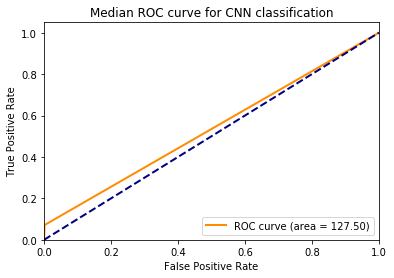

<Figure size 432x288 with 0 Axes>

In [46]:
roc_av = roc_auc
roc_av = median(roc_av)
plt.figure()
plt.plot(fpr[100], tpr[100], color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_av)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Median ROC curve for CNN classification')
plt.legend(loc="lower right")
plt.show()
plt.savefig("./cnnaverage.png")

/home/jordan/.conda/envs/tensorflow-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  if __name__ == '__main__':
No handles with labels found to put in legend.


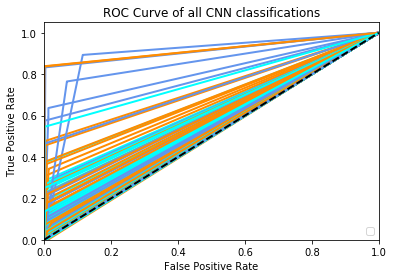

<Figure size 432x288 with 0 Axes>

In [47]:
n_classes = 256
lw = 2
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw)

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of all CNN classifications')
plt.legend(loc="lower right")
plt.show()
plt.savefig("./cnnall.png")

In [27]:
roc_auc

{0: nan,
 1: 0.5189577540511252,
 2: 0.5651917404129793,
 3: 0.6230963076585954,
 4: 0.49983583233008644,
 5: 0.5107601201041156,
 6: 0.4992343869627037,
 7: 0.5,
 8: 0.4999451814494025,
 9: 0.4998361908922136,
 10: 0.4978714114179675,
 11: 0.511653498506459,
 12: 0.6417763157894737,
 13: 0.515850622406639,
 14: 0.4998907939281424,
 15: 0.5602235469448584,
 16: 0.5370418595273897,
 17: 0.5,
 18: 0.5160743993909317,
 19: 0.5115732023815582,
 20: 0.5825690577573972,
 21: 0.6358600503337345,
 22: 0.5382431263178232,
 23: 0.5480592995713963,
 24: 0.5160743993909317,
 25: 0.5130214951448276,
 26: 0.5132329361174883,
 27: 0.54,
 28: 0.4992899279003714,
 29: 0.515910500789533,
 30: 0.5,
 31: 0.4999453731017153,
 32: 0.5696340797378482,
 33: 0.5331148257401945,
 34: 0.5450179118992567,
 35: 0.5598908058528063,
 36: 0.6850979910470575,
 37: 0.572375041014984,
 38: 0.5,
 39: 0.5173717295276928,
 40: 0.4997813968739753,
 41: 0.550686340246962,
 42: 0.49989081777486627,
 43: 0.5134588448058817,
 4

In [40]:
roc_auc

{0: nan,
 1: 0.5189577540511252,
 2: 0.5651917404129793,
 3: 0.6230963076585954,
 4: 0.49983583233008644,
 5: 0.5107601201041156,
 6: 0.4992343869627037,
 7: 0.5,
 8: 0.4999451814494025,
 9: 0.4998361908922136,
 10: 0.4978714114179675,
 11: 0.511653498506459,
 12: 0.6417763157894737,
 13: 0.515850622406639,
 14: 0.4998907939281424,
 15: 0.5602235469448584,
 16: 0.5370418595273897,
 17: 0.5,
 18: 0.5160743993909317,
 19: 0.5115732023815582,
 20: 0.5825690577573972,
 21: 0.6358600503337345,
 22: 0.5382431263178232,
 23: 0.5480592995713963,
 24: 0.5160743993909317,
 25: 0.5130214951448276,
 26: 0.5132329361174883,
 27: 0.54,
 28: 0.4992899279003714,
 29: 0.515910500789533,
 30: 0.5,
 31: 0.4999453731017153,
 32: 0.5696340797378482,
 33: 0.5331148257401945,
 34: 0.5450179118992567,
 35: 0.5598908058528063,
 36: 0.6850979910470575,
 37: 0.572375041014984,
 38: 0.5,
 39: 0.5173717295276928,
 40: 0.4997813968739753,
 41: 0.550686340246962,
 42: 0.49989081777486627,
 43: 0.5134588448058817,
 4